##Imports


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
import sys

# Add the src directory to the system path
src_path = '/content/drive/MyDrive/Signature_Project/src'
if src_path not in sys.path:
    sys.path.append(src_path)

from preprocess import preprocess_image
from features import extract_features

Mounted at /content/drive


##Paths

In [ ]:
DATA_DIR = os.path.join('/content/drive/MyDrive/Signature_Project/data', "signatures")
GENUINE_DIR = os.path.join(DATA_DIR, "full_org")
FORGED_DIR = os.path.join(DATA_DIR, "full_forg")

def load_dataset():
    X, y = [], []
    for path, label in [(GENUINE_DIR, 1), (FORGED_DIR, 0)]:
        for f in os.listdir(path):
            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                X.append(os.path.join(path, f))
                y.append(label)
    return X, np.array(y)

image_paths, labels = load_dataset()
print(f"Loaded {len(image_paths)} images (genuine={np.sum(labels == 1)}, forged={np.sum(labels == 0)})")

Loaded 2640 images (genuine=1320, forged=1320)


##Load images and labels

In [ ]:
def load_dataset():
    X, y = [], []
    for path, label in [(GENUINE_DIR, 1), (FORGED_DIR, 0)]:
        for f in os.listdir(path):
            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                X.append(os.path.join(path, f))
                y.append(label)
    return X, np.array(y)

image_paths, labels = load_dataset()

##Preprocess and extract features

In [ ]:
features = []
for path in image_paths:
    img = preprocess_image(path)
    feat = extract_features(img)
    features.append(feat)

X = np.array(features)
y = labels

print(f"Feature matrix shape: {X.shape}")

Feature matrix shape: (2640, 3795)


##EDA

✅ Dataset loaded for EDA
Shape: (2640, 3796)
label
1    1320
0    1320
Name: count, dtype: int64


/tmp/ipython-input-2322571631.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='Set2')


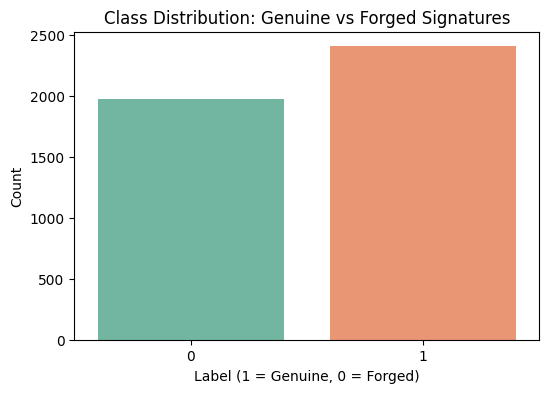


📊 Basic Statistical Summary:


,count,mean,std,min,25%,50%,75%,max
0,2640.0,1589.705492,1388.103350,94.500000,687.500000,1174.250000,2008.875000,12406.500000
1,2640.0,1.657298,0.965454,0.051724,0.926142,1.455051,2.201020,6.576923
2,2640.0,0.171294,0.101988,0.018402,0.100136,0.148155,0.214456,0.728765
3,2640.0,1.124582,1.343002,0.229051,0.475046,0.733073,1.324972,42.258727
4,2640.0,0.955146,0.507363,0.265676,0.578161,0.831259,1.160820,4.284017
5,2640.0,0.005623,0.048262,0.000000,0.000000,0.000000,0.000000,0.707107
6,2640.0,0.001719,0.018927,0.000000,0.000000,0.000000,0.000000,0.348826
7,2640.0,0.003739,0.033698,0.000000,0.000000,0.000000,0.000000,0.521025
8,2640.0,0.001012,0.011074,0.000000,0.000000,0.000000,0.000000,0.242195
9,2640.0,0.003531,0.030493,0.000000,0.000000,0.000000,0.000000,0.707107


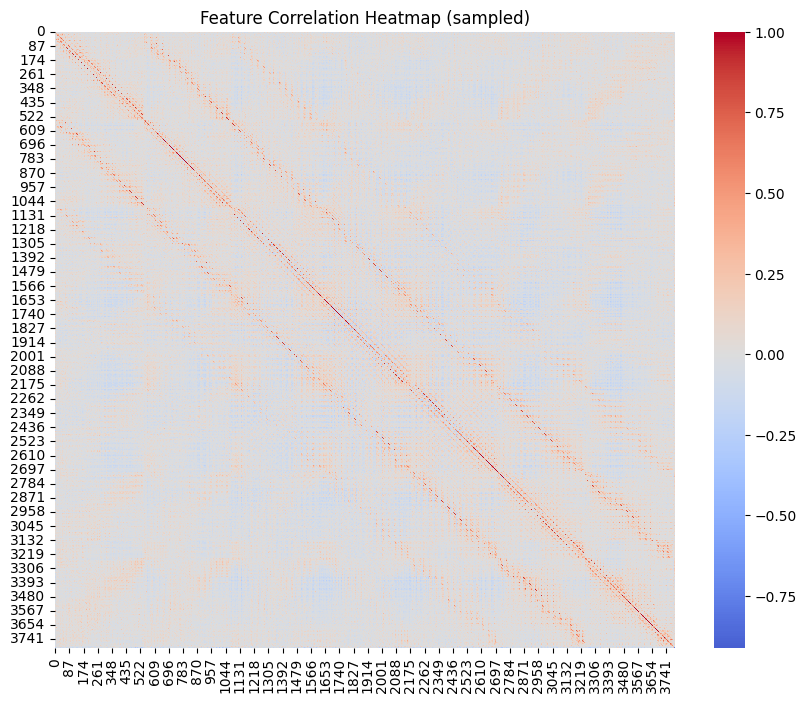

Performing PCA for 2D visualization...


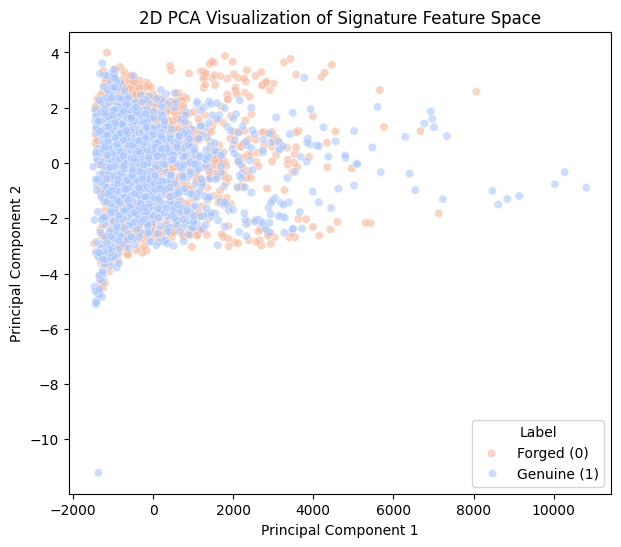

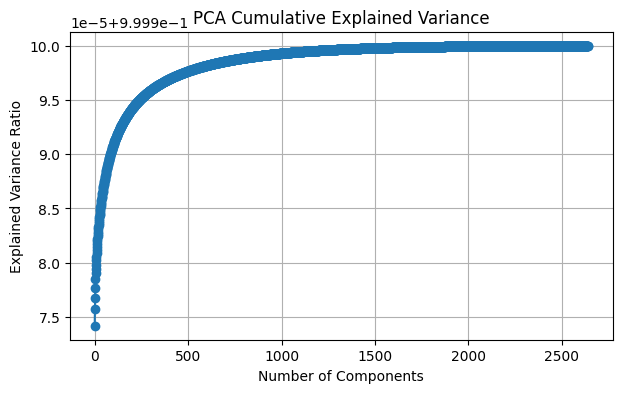

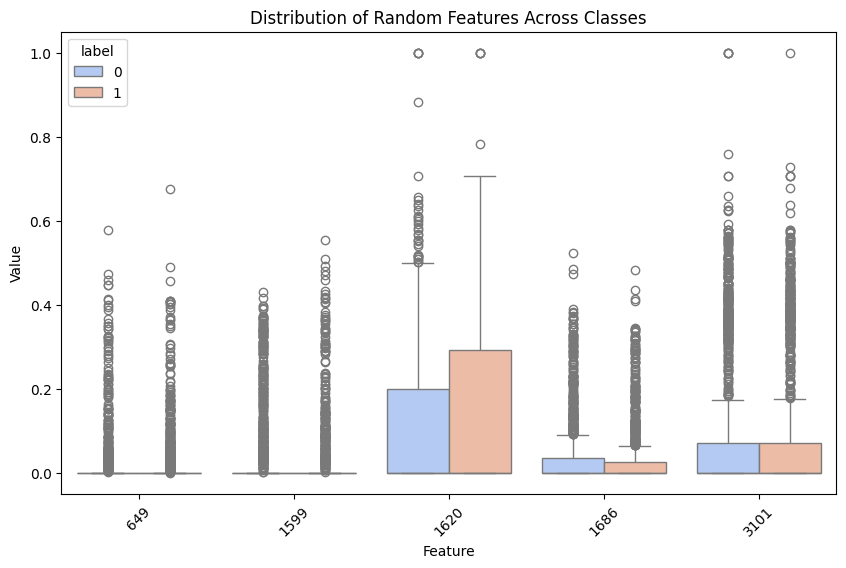

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# ============================================================
# Convert feature matrix and labels into a DataFrame
# ============================================================
df = pd.DataFrame(X)
df['label'] = y

print("✅ Dataset loaded for EDA")
print("Shape:", df.shape)
print(df['label'].value_counts())

# ============================================================
# Class Distribution
# ============================================================
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df, palette='Set2')
plt.title("Class Distribution: Genuine vs Forged Signatures")
plt.xlabel("Label (1 = Genuine, 0 = Forged)")
plt.ylabel("Count")
plt.show()

# ============================================================
# Feature Statistics Overview
# ============================================================
print("\n📊 Basic Statistical Summary:")
display(df.describe().T.head(10))

# ============================================================
# Correlation Heatmap (sampled for speed)
# ============================================================
sample_df = df.sample(min(1000, len(df)), random_state=42)
corr = sample_df.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Feature Correlation Heatmap (sampled)")
plt.show()

# ============================================================
# PCA Visualization (2D)
# ============================================================
print("Performing PCA for 2D visualization...")
pca_vis = PCA(n_components=2)
X_pca = pca_vis.fit_transform(X)

plt.figure(figsize=(7,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y, alpha=0.6, palette='coolwarm')
plt.title("2D PCA Visualization of Signature Feature Space")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Label", labels=["Forged (0)", "Genuine (1)"])
plt.show()

# ============================================================
#PCA Explained Variance (how many components matter)
# ============================================================
pca_full = PCA().fit(X)

plt.figure(figsize=(7,4))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_), marker='o')
plt.title("PCA Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance Ratio")
plt.grid(True)
plt.show()



##train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (2112, 3795)
Testing data shape: (528, 3795)


##Pipelines and training



Training LogisticRegression...
              precision    recall  f1-score   support

           0       0.79      0.75      0.77       264
           1       0.76      0.80      0.78       264

    accuracy                           0.77       528
   macro avg       0.78      0.77      0.77       528
weighted avg       0.78      0.77      0.77       528

AUC: 0.8524


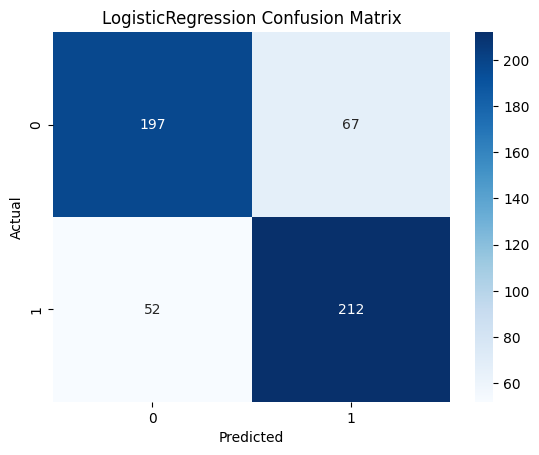


Training SVM...
              precision    recall  f1-score   support

           0       0.88      0.89      0.89       264
           1       0.89      0.88      0.88       264

    accuracy                           0.88       528
   macro avg       0.88      0.88      0.88       528
weighted avg       0.88      0.88      0.88       528

AUC: 0.9549


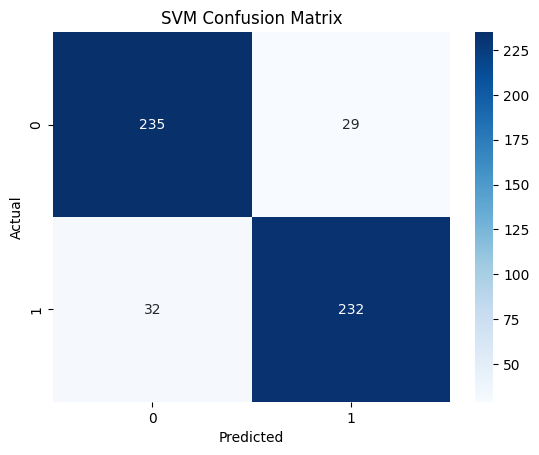


Training DecisionTree...
              precision    recall  f1-score   support

           0       0.72      0.68      0.70       264
           1       0.70      0.73      0.71       264

    accuracy                           0.71       528
   macro avg       0.71      0.71      0.71       528
weighted avg       0.71      0.71      0.71       528

AUC: 0.6958


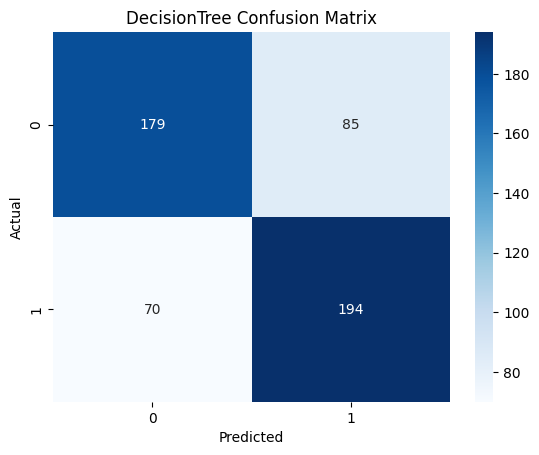


Training SGDClassifier...
              precision    recall  f1-score   support

           0       0.77      0.79      0.78       264
           1       0.78      0.77      0.77       264

    accuracy                           0.78       528
   macro avg       0.78      0.78      0.78       528
weighted avg       0.78      0.78      0.78       528

AUC: 0.8116


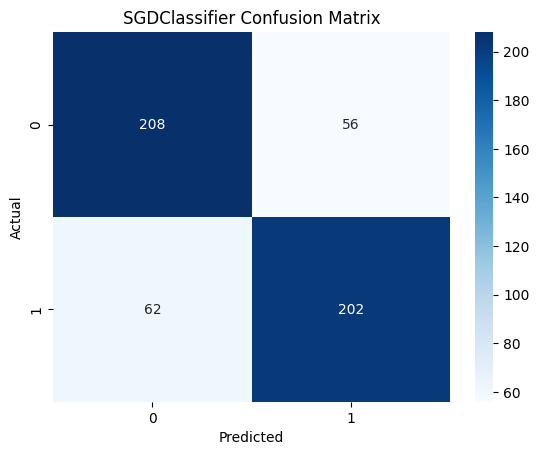

Equal Error Rate (EER) for the best model (SVM): 11.74%


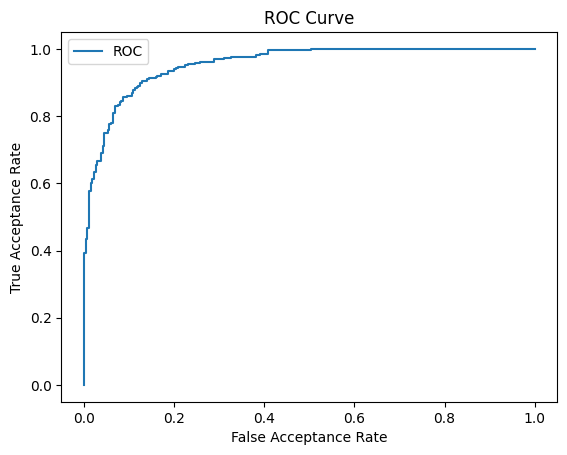

Model saved at ../models/best_signature_model.joblib


In [ ]:
# Define pipelines
def make_pipeline(model):
    return Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.95)),
        ('clf', model)
    ])

models = {
    "LogisticRegression": LogisticRegression(max_iter=2000, class_weight='balanced'),
    "SVM": SVC(kernel='rbf', probability=True, class_weight='balanced'),
    "DecisionTree": DecisionTreeClassifier(max_depth=10, class_weight='balanced'),
    "SGDClassifier": SGDClassifier(loss='log_loss', max_iter=1000, class_weight='balanced')
}


results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    pipe = make_pipeline(model)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)[:,1] if hasattr(pipe, "predict_proba") else None

    print(classification_report(y_test, y_pred))
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None
    print(f"AUC: {auc:.4f}" if auc else "No probability output for AUC.")

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.show()

    results[name] = {"model": pipe, "AUC": auc}


best_model_name = max(results.items(), key=lambda kv: kv[1]["AUC"] if kv[1]["AUC"] else 0)[0]
best_model = results[best_model_name]["model"]
y_score = best_model.predict_proba(X_test)[:,1]
fpr, tpr, thr = roc_curve(y_test, y_score)
FAR = fpr
FRR = 1 - tpr
eer_index = np.argmin(np.abs(FAR - FRR))
EER = (FAR[eer_index] + FRR[eer_index]) / 2
print(f"Equal Error Rate (EER) for the best model ({best_model_name}): {EER*100:.2f}%")

plt.plot(FAR, 1-FRR, label='ROC')
plt.xlabel('False Acceptance Rate')
plt.ylabel('True Acceptance Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


os.makedirs("../models", exist_ok=True)
joblib.dump(best_model, "../models/best_signature_model.joblib")
print("Model saved at ../models/best_signature_model.joblib")

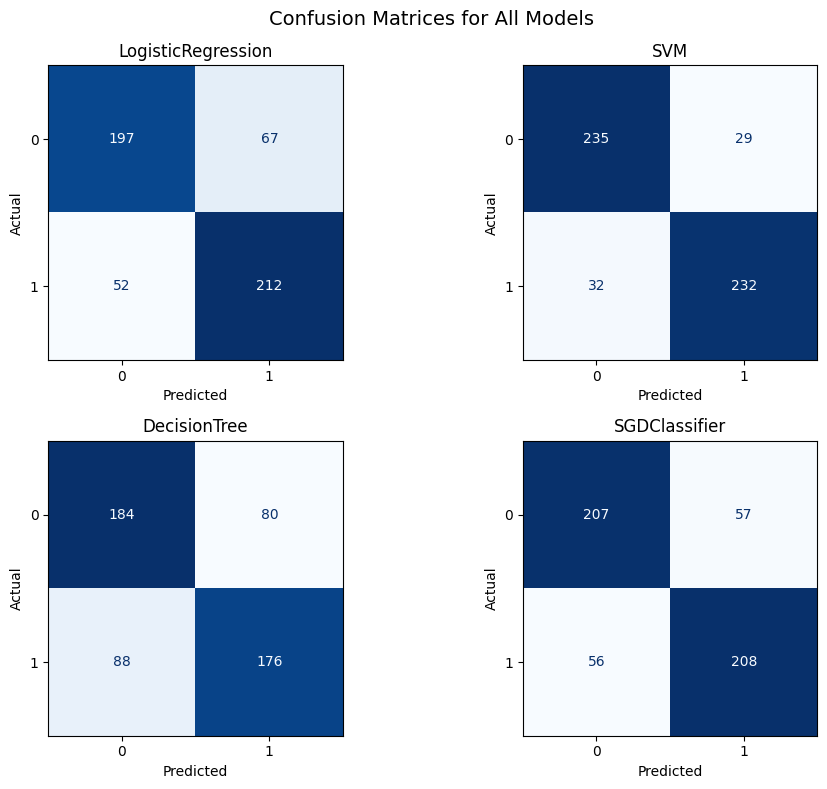

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


n_models = len(results)
cols = 2
rows = (n_models + 1) // 2


fig, axes = plt.subplots(rows, cols, figsize=(10, 8))
axes = axes.flatten()

for idx, (name, info) in enumerate(results.items()):
    model = info["model"]
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)

    disp.plot(ax=axes[idx], cmap='Blues', colorbar=False)
    axes[idx].set_title(f"{name}")
    axes[idx].set_xlabel("Predicted")
    axes[idx].set_ylabel("Actual")


for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Confusion Matrices for All Models", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd


confusion_results = {}

for name, res in results.items():
    model = res["model"]
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        confusion_results[name] = {
            "True Positive (TP)": tp,
            "False Positive (FP)": fp,
            "False Negative (FN)": fn,
            "True Negative (TN)": tn
        }
    else:
        print(f" Skipping {name}: not a binary confusion matrix")

confusion_df = pd.DataFrame(confusion_results).T
print(" Confusion Matrix Breakdown per Model:")
display(confusion_df)


 Confusion Matrix Breakdown per Model:


,True Positive (TP),False Positive (FP),False Negative (FN),True Negative (TN)
LogisticRegression,212,67,52,197
SVM,232,29,32,235
DecisionTree,176,80,88,184
SGDClassifier,208,57,56,207


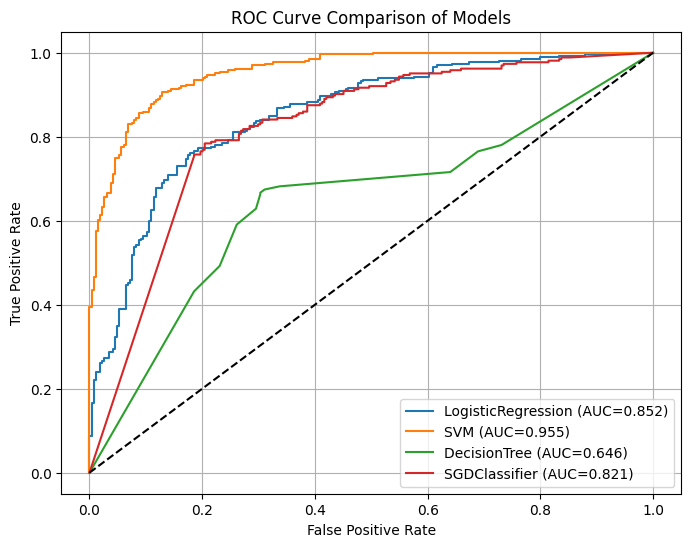

,Accuracy,Precision,Recall,F1-Score,AUC
Model,,,,,
LogisticRegression,0.775,0.760,0.803,0.781,0.852
SVM,0.884,0.889,0.879,0.884,0.955
DecisionTree,0.682,0.688,0.667,0.677,0.646
SGDClassifier,0.786,0.785,0.788,0.786,0.821


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd

metrics_summary = []

plt.figure(figsize=(8,6))
for name, info in results.items():
    model = info["model"]

    # Predictions & probabilities
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = None

    # Compute metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan

    metrics_summary.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1,
        "AUC": auc
    })

    # Plot ROC curve
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison of Models")
plt.legend()
plt.grid(True)
plt.show()

# --- Create and display metrics table ---
df_metrics = pd.DataFrame(metrics_summary)
df_metrics.set_index("Model", inplace=True)
display(df_metrics.style.format({
    "Accuracy": "{:.3f}",
    "Precision": "{:.3f}",
    "Recall": "{:.3f}",
    "F1-Score": "{:.3f}",
    "AUC": "{:.3f}"
}).set_properties(**{'text-align': 'center'}))

##Model performance Evaluation on test set

Model Performance Summary:


,Accuracy,Precision,Recall,F1 Score,AUC
LogisticRegression,0.775,0.760,0.803,0.781,0.852
SVM,0.884,0.889,0.879,0.884,0.955
DecisionTree,0.682,0.688,0.667,0.677,0.646
SGDClassifier,0.786,0.785,0.788,0.786,0.821


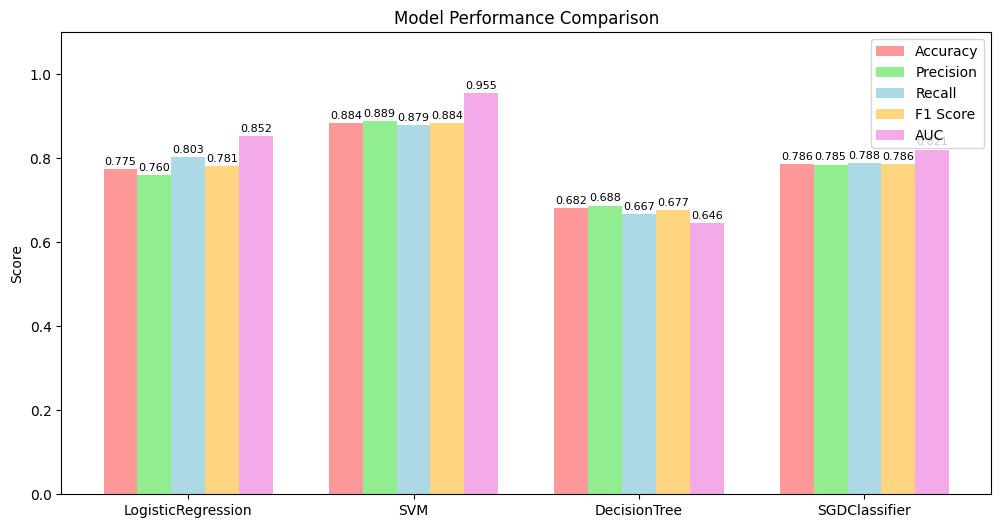

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


performance = {}

for name, res in results.items():
    model = res["model"]
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None

    performance[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1 Score": f1_score(y_test, y_pred, zero_division=0),
        "AUC": roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan
    }


perf_df = pd.DataFrame(performance).T
print("Model Performance Summary:")
display(perf_df.round(3))

plt.figure(figsize=(12,6))
bar_width = 0.15
x = np.arange(len(perf_df.index))

colors = ['#FF9999','#90EE90','#ADD8E6','#FFD580','#F4A9E8']
metrics = ["Accuracy","Precision","Recall","F1 Score","AUC"]

for i, metric in enumerate(metrics):
    plt.bar(x + i*bar_width, perf_df[metric], width=bar_width, label=metric, color=colors[i])
    for j, val in enumerate(perf_df[metric]):
        plt.text(x[j] + i*bar_width, val + 0.01, f"{val:.3f}", ha='center', fontsize=8)

plt.xticks(x + bar_width*(len(metrics)/2 - 0.5), perf_df.index)
plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.legend()
plt.ylim(0, 1.1)
plt.show()

Model loaded successfully.

Classification Report for the loaded model:
              precision    recall  f1-score   support

           0       0.88      0.89      0.89       264
           1       0.89      0.88      0.88       264

    accuracy                           0.88       528
   macro avg       0.88      0.88      0.88       528
weighted avg       0.88      0.88      0.88       528

AUC for the loaded model: 0.9549


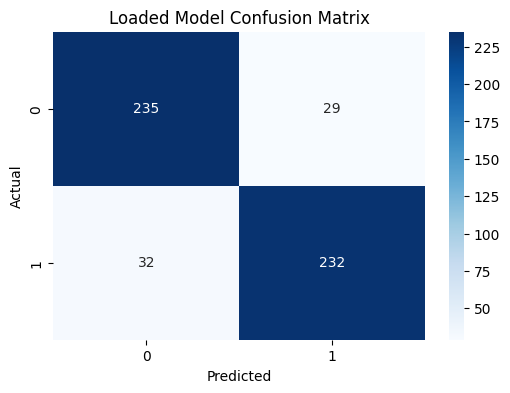

In [ ]:
import joblib
import os
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the best model
model_path = "../models/best_signature_model.joblib"
if os.path.exists(model_path):
    loaded_model = joblib.load(model_path)
    print("Model loaded successfully.")

    # Evaluate the loaded model on the test set
    y_pred_loaded = loaded_model.predict(X_test)

    print("\nClassification Report for the loaded model:")
    print(classification_report(y_test, y_pred_loaded))

    if hasattr(loaded_model, "predict_proba"):
        y_prob_loaded = loaded_model.predict_proba(X_test)[:, 1]
        auc_loaded = roc_auc_score(y_test, y_prob_loaded)
        print(f"AUC for the loaded model: {auc_loaded:.4f}")
    else:
        print("Loaded model does not have predict_proba for AUC calculation.")



    cm_loaded = confusion_matrix(y_test, y_pred_loaded)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_loaded, annot=True, fmt="d", cmap="Blues")
    plt.title("Loaded Model Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.show()

else:
    print(f"Model file not found at {model_path}")

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

# Assuming y_test and y_pred_loaded are available from the previous cell execution
report = classification_report(y_test, y_pred_loaded, output_dict=True)

metrics_data = {
    "Metric": ["Accuracy", "Precision (Forged)", "Recall (Forged)", "F1-Score (Forged)",
               "Precision (Genuine)", "Recall (Genuine)", "F1-Score (Genuine)", "AUC"],
    "Score": [
        report['accuracy'],
        report['0']['precision'],
        report['0']['recall'],
        report['0']['f1-score'],
        report['1']['precision'],
        report['1']['recall'],
        report['1']['f1-score'],
        auc_loaded if 'auc_loaded' in locals() else 'N/A' # Include AUC if calculated
    ]
}

metrics_df = pd.DataFrame(metrics_data)
display(metrics_df)

,Metric,Score
0,Accuracy,0.884470
1,Precision (Forged),0.880150
2,Recall (Forged),0.890152
3,F1-Score (Forged),0.885122
4,Precision (Genuine),0.888889
5,Recall (Genuine),0.878788
6,F1-Score (Genuine),0.883810
7,AUC,0.954947


##Testing on new image

In [ ]:
import joblib
import numpy as np
from preprocess import preprocess_image
from features import extract_features

model_path = "../models/best_signature_model.joblib"
model = joblib.load(model_path)
print("Model loaded successfully!")


test_image_path = "/content/2.jpg"

# Preprocess and extract features
img = preprocess_image(test_image_path)
features = extract_features(img).reshape(1, -1)


prob = model.predict_proba(features)[0][1] * 100  # Probability of being genuine
prediction = "Genuine" if prob >= 50 else "Forged"

print(f"\n Signature Test Result:")
print(f"Predicted Class : {prediction}")
print(f"Genuineness Probability : {prob:.2f}%")


✅ Model loaded successfully!

🖋️ Signature Test Result:
Predicted Class : Genuine
Genuineness Probability : 96.46%


## Imports and Setup

## Data Loading and Preprocessing

In [ ]:
from google.colab import files
model_path = '../models/best_signature_model.joblib'
files.download(model_path)
print(f"Download link generated for {model_path}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download link generated for ../models/best_signature_model.joblib


In [ ]:
from google.colab import files
model_path = '../models/best_signature_model.joblib' # Note the correct path
files.download(model_path)
print(f"Download link generated for {model_path}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download link generated for ../models/best_signature_model.joblib


# Task
Optimize the machine learning model to improve prediction accuracy while preventing overfitting.

## Explore hyperparameter tuning

### Subtask:
Use GridSearchCV to find the best hyperparameters for the SVM model.


**Reasoning**:
The current subtask is to use GridSearchCV to find the best hyperparameters for the SVM model. This involves importing GridSearchCV, defining a parameter grid, creating and fitting the GridSearchCV object, and printing the best parameters.



Best parameters found by GridSearchCV:
{'clf__C': 10, 'clf__gamma': 0.01, 'clf__kernel': 'rbf'}
Best cross-validation AUC score:
0.8994611419593662

Classification Report for the best SVM model:
              precision    recall  f1-score   support

           0       1.00      0.02      0.03       264
           1       0.50      1.00      0.67       264

    accuracy                           0.51       528
   macro avg       0.75      0.51      0.35       528
weighted avg       0.75      0.51      0.35       528

AUC for the best SVM model: 0.5113


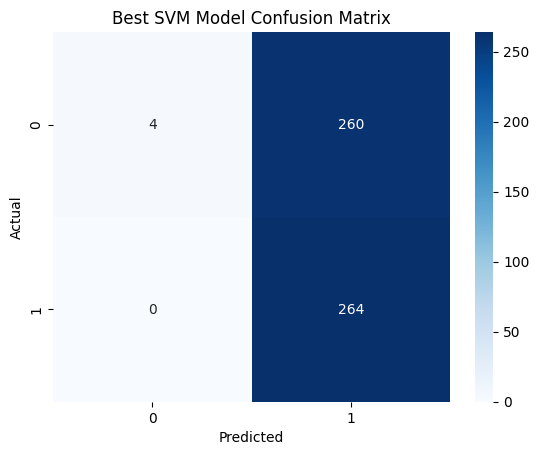

Equal Error Rate (EER) for the best SVM model: 49.43%


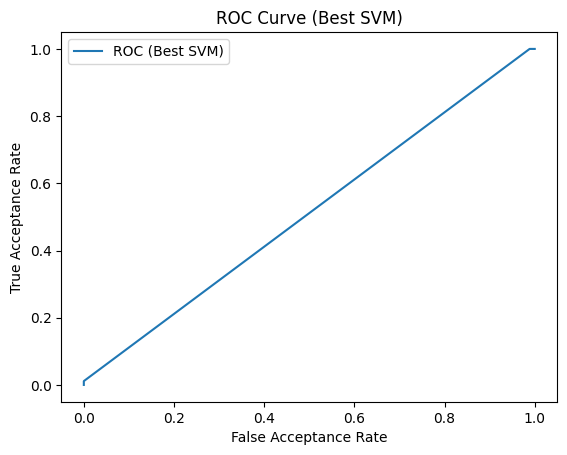

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for SVM (reduced for faster execution)
param_grid = {
    'clf__C': [1, 10], # Reduced C values
    'clf__gamma': [0.1, 0.01], # Reduced gamma values
    'clf__kernel': ['rbf']
}

# Create the SVM pipeline
svm_pipe = make_pipeline(SVC(probability=True, class_weight='balanced'))

# Create the GridSearchCV object
grid_search = GridSearchCV(svm_pipe, param_grid, cv=3, scoring='roc_auc', n_jobs=-1) # Reduced cross-validation folds

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)
print("Best cross-validation AUC score:")
print(grid_search.best_score_)

# Evaluate the best model on the test set
best_svm_model = grid_search.best_estimator_
y_pred_best_svm = best_svm_model.predict(X_test)
y_prob_best_svm = best_svm_model.predict_proba(X_test)[:, 1]

print("\nClassification Report for the best SVM model:")
print(classification_report(y_test, y_pred_best_svm))
print(f"AUC for the best SVM model: {roc_auc_score(y_test, y_prob_best_svm):.4f}")

cm_best_svm = confusion_matrix(y_test, y_pred_best_svm)
sns.heatmap(cm_best_svm, annot=True, fmt="d", cmap="Blues")
plt.title("Best SVM Model Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.show()

# Compute FAR / FRR / EER for the best SVM model
y_score_best_svm = best_svm_model.predict_proba(X_test)[:,1]
fpr_best_svm, tpr_best_svm, thr_best_svm = roc_curve(y_test, y_score_best_svm)
FAR_best_svm = fpr_best_svm
FRR_best_svm = 1 - tpr_best_svm
eer_index_best_svm = np.argmin(np.abs(FAR_best_svm - FRR_best_svm))
EER_best_svm = (FAR_best_svm[eer_index_best_svm] + FRR_best_svm[eer_index_best_svm]) / 2
print(f"Equal Error Rate (EER) for the best SVM model: {EER_best_svm*100:.2f}%")

plt.plot(FAR_best_svm, 1-FRR_best_svm, label='ROC (Best SVM)')
plt.xlabel('False Acceptance Rate')
plt.ylabel('True Acceptance Rate')
plt.title('ROC Curve (Best SVM)')
plt.legend()
plt.show()

In [ ]:
# Colab EDA figure generator with auto-detection of dataset root
# Generates: class distribution, images-per-writer, image formats, dims/aspect, foreground coverage, montages, split-schema.

import os, sys, glob, math, random, pathlib, subprocess, importlib.util
from pathlib import Path

def _ensure(pkg, import_name=None):
    name = import_name or pkg
    if importlib.util.find_spec(name) is None:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg, "-q"])
    return importlib.import_module(name)

# Mount Drive (Colab-safe)
def _in_colab():
    try:
        import google.colab  # type: ignore
        return True
    except Exception:
        return False

if _in_colab():
    try:
        from google.colab import drive  # type: ignore
        drive.mount("/content/drive")
    except Exception:
        pass

# Deps
np = _ensure("numpy")
pd = _ensure("pandas")
cv2 = _ensure("opencv-python", "cv2")
plt = _ensure("matplotlib").pyplot
sns = _ensure("seaborn")

sns.set(style="whitegrid", context="notebook")
plt.rcParams["figure.dpi"] = 120

# ---------- Auto-detect DATA_ROOT ----------
# Accept env override SIGN_DATA_BASE; else search MyDrive for dirs containing both Genuine and Forged (with common name variants).
VARIANTS_G = {"genuine", "authentic", "real", "true", "original", "org", "full_org"}
VARIANTS_F = {"forged", "forgery", "fake", "imposter", "forg", "full_forg"}

def has_class_dir(parent: Path) -> bool:
    if not parent.is_dir():
        return False
    names = {p.name.lower() for p in parent.iterdir() if p.is_dir()}
    return any(g in names for g in VARIANTS_G) and any(f in names for f in VARIANTS_F)

def find_dataset_root(start: Path, max_dirs=4000) -> Path | None:
    """Scan for parent folders that contain both a Genuine-like and a Forged-like subfolder."""
    candidates = set()
    n = 0
    for p in start.rglob("*"):
        if not p.is_dir():
            continue
        n += 1
        if n > max_dirs:
            break
        name = p.name.lower()
        if name in VARIANTS_G or name in VARIANTS_F:
            parent = p.parent
            if has_class_dir(parent):
                candidates.add(parent)
    if not candidates:
        return None
    # Rank candidates by number of image files under them; pick the largest
    exts = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff", ".webp"}
    def count_imgs(root: Path) -> int:
        return sum(1 for q in root.rglob("*") if q.suffix.lower() in exts)
    ranked = sorted(candidates, key=count_imgs, reverse=True)
    return ranked[0]

# Resolve DATA_ROOT
if _in_colab():
    DEFAULT_SEARCH_ROOT = Path("/content/drive/MyDrive")
    OUTPUT_DIR = Path("/content/eda_figures")
else:
    DEFAULT_SEARCH_ROOT = Path.cwd()
    OUTPUT_DIR = Path("./eda_figures")

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

DATA_ROOT_ENV = os.environ.get("SIGN_DATA_BASE", "").strip()
if DATA_ROOT_ENV:
    DATA_ROOT = Path(DATA_ROOT_ENV)
else:
    DATA_ROOT = find_dataset_root(DEFAULT_SEARCH_ROOT)

if not DATA_ROOT or not DATA_ROOT.exists():
    print("[ERROR] Could not auto-detect dataset root.")
    print("Set an explicit path then re-run this cell, e.g.:")
    print("  os.environ['SIGN_DATA_BASE'] = '/content/drive/MyDrive/path/to/your/dataset'")
    raise SystemExit(1)

print(f"[info] Using DATA_ROOT = {DATA_ROOT.resolve()}")
print(f"[info] Figures will be saved in {OUTPUT_DIR.resolve()}")

# ---------- Helpers ----------
IMG_EXTS = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff", ".webp"}

def is_img(p: Path) -> bool:
    return p.suffix.lower() in IMG_EXTS

def infer_class_from_path(p: Path) -> str | None:
    parts = [x.lower() for x in p.parts]
    if any(tok in parts for tok in VARIANTS_G):
        return "Genuine"
    if any(tok in parts for tok in VARIANTS_F):
        return "Forged"
    return None

def infer_writer_id(p: Path) -> str:
    # Prefer parent of class folder as writer id
    for parent in p.parents:
        name = parent.name.lower()
        if name in VARIANTS_G or name in VARIANTS_F:
            gp = parent.parent
            if gp and gp != DATA_ROOT and gp.name.lower() not in VARIANTS_G | VARIANTS_F:
                return gp.name
    # Fallback: first segment under DATA_ROOT that isn't a class name
    try:
        rel = p.relative_to(DATA_ROOT)
        for seg in rel.parts:
            if seg.lower() not in VARIANTS_G | VARIANTS_F:
                return seg
    except Exception:
        pass
    return "unknown"

def imread_gray(path: Path):
    data = np.fromfile(str(path), dtype=np.uint8)
    return cv2.imdecode(data, cv2.IMREAD_GRAYSCALE)

def foreground_ratio_otsu(gray: np.ndarray) -> float:
    blur = cv2.GaussianBlur(gray, (3, 3), 0)
    _, th = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    th = 255 - th
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    th = cv2.morphologyEx(th, cv2.MORPH_OPEN, k)
    th = cv2.morphologyEx(th, cv2.MORPH_CLOSE, k)
    return float((th > 0).sum()) / float(th.size)

def montage(df: pd.DataFrame, cls: str, out_name: str, n=12, cols=6):
    sub = df[df["label"] == cls]
    if sub.empty:
        return
    paths = sub.sample(n=min(n, len(sub)), random_state=42)["path"].tolist()
    thumbs = []
    for p in paths:
        g = imread_gray(Path(p))
        if g is None:
            continue
        h, w = g.shape
        m = max(h, w)
        canvas = np.zeros((m, m), dtype=np.uint8)
        y0, x0 = (m - h) // 2, (m - w) // 2
        canvas[y0:y0 + h, x0:x0 + w] = g
        thumbs.append(canvas)
    if not thumbs:
        return
    rows = math.ceil(len(thumbs) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.0, rows * 2.0))
    axes = np.array(axes).reshape(rows, cols)
    k = 0
    for r in range(rows):
        for c in range(cols):
            ax = axes[r, c]
            ax.axis("off")
            if k < len(thumbs):
                ax.imshow(thumbs[k], cmap="gray")
                k += 1
    fig.tight_layout()
    fig.savefig(OUTPUT_DIR / out_name, dpi=200)
    plt.close(fig)

# ---------- Build metadata ----------
all_files = [p for p in DATA_ROOT.rglob("*") if p.is_file() and is_img(p)]
if not all_files:
    print("[ERROR] No images found under:", DATA_ROOT)
    raise SystemExit(2)

records = []
for p in all_files:
    label = infer_class_from_path(p)
    if label is None:
        continue
    img = imread_gray(p)
    if img is None:
        continue
    h, w = img.shape[:2]
    fr = foreground_ratio_otsu(img)
    records.append({
        "path": str(p),
        "label": label,
        "writer_id": infer_writer_id(p),
        "width": w,
        "height": h,
        "aspect": (w / h) if h else np.nan,
        "ext": p.suffix.lower(),
        "foreground_ratio": fr
    })

df = pd.DataFrame.from_records(records)
if df.empty:
    print("[ERROR] No labeled images (couldn't infer Genuine/Forged from folder names).")
    print("Rename class folders to include one of:", sorted(VARIANTS_G), "and", sorted(VARIANTS_F))
    raise SystemExit(3)

print(f"[info] Images: {len(df)} | Genuine={int((df.label=='Genuine').sum())} | Forged={int((df.label=='Forged').sum())}")
print(df.head(3))

# ---------- Figures ----------
# 1) Montages
montage(df, "Genuine", "fig_7_1_example_signatures_genuine.png")
montage(df, "Forged",  "fig_7_1_example_signatures_forged.png")

# 2) Class distribution
fig, ax = plt.subplots(figsize=(5, 4))
sns.countplot(data=df, x="label", order=["Genuine", "Forged"], palette="Set2", ax=ax)
ax.set_title("Class Distribution")
ax.set_xlabel("")
ax.set_ylabel("Count")
fig.tight_layout()
fig.savefig(OUTPUT_DIR / "fig_7_2_class_distribution.png", dpi=200)
plt.close(fig)

# 3) Images per writer (top 40 by count)
wc = df.groupby(["writer_id", "label"]).size().reset_index(name="count")
if wc["writer_id"].nunique() > 1:
    wc_top = wc.sort_values("count", ascending=False).head(40)
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.barplot(data=wc_top, x="writer_id", y="count", hue="label", palette="Set2", ax=ax)
    ax.set_title("Images per Writer (Top 40)")
    ax.set_xlabel("Writer ID")
    ax.set_ylabel("Count")
    plt.xticks(rotation=90)
    fig.tight_layout()
    fig.savefig(OUTPUT_DIR / "fig_7_2b_images_per_writer.png", dpi=200)
    plt.close(fig)

# 4) Image formats
fig, ax = plt.subplots(figsize=(5, 4))
order = df["ext"].value_counts().index
sns.countplot(data=df, x="ext", order=order, palette="pastel", ax=ax)
ax.set_title("Image Format Distribution")
ax.set_xlabel("Extension")
ax.set_ylabel("Count")
fig.tight_layout()
fig.savefig(OUTPUT_DIR / "fig_7_2c_image_formats.png", dpi=200)
plt.close(fig)

# 5) Dimensions & Aspect
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
sns.histplot(df["width"],  bins=30, ax=axes[0], color="#5B8E7D")
axes[0].set_title("Width")
sns.histplot(df["height"], bins=30, ax=axes[1], color="#7DAEA3")
axes[1].set_title("Height")
sns.histplot(df["aspect"], bins=30, ax=axes[2], color="#D3A588")
axes[2].set_title("Aspect (W/H)")
for a in axes: a.set_xlabel("")
fig.tight_layout()
fig.savefig(OUTPUT_DIR / "fig_7_2d_dims_aspect.png", dpi=200)
plt.close(fig)

# 6) Foreground coverage
fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(df["foreground_ratio"].dropna(), bins=30, kde=False, color="#6C63FF", ax=ax)
ax.set_title("Foreground Coverage (Otsu)")
ax.set_xlabel("Foreground Pixel Fraction")
ax.set_ylabel("Count")
fig.tight_layout()
fig.savefig(OUTPUT_DIR / "fig_7_2e_foreground_ratio.png", dpi=200)
plt.close(fig)

# 7) Split schema placeholder (writer-disjoint)
fig, ax = plt.subplots(figsize=(8, 3.5))
ax.axis("off")
ax.set_title("Writer-Disjoint, Stratified Split Schema", fontsize=14, pad=10)
ax.set_xlim(0, 10); ax.set_ylim(0, 4)
def blk(xy, w, h, color, text):
    r = plt.Rectangle(xy, w, h, facecolor=color, edgecolor="black")
    ax.add_patch(r); ax.text(xy[0]+w/2, xy[1]+h/2, text, ha="center", va="center", fontsize=10)
blk((0.5, 1.2), 3.0, 1.1, "#ccebc5", "Train (80%)\nWriters A..M")
blk((4.1, 1.2), 2.2, 1.1, "#ffe0b2", "Val (10%)\nWriters N..P")
blk((6.9, 1.2), 2.6, 1.1, "#fbb4ae", "Test (10%)\nWriters Q..R")
ax.annotate("", xy=(4.1,1.75), xytext=(3.6,1.75), arrowprops=dict(arrowstyle="->"))
ax.annotate("", xy=(6.9,1.75), xytext=(6.3,1.75), arrowprops=dict(arrowstyle="->"))
ax.text(0.5, 0.35, "No writer appears in multiple splits.\nPreserve class proportions.", fontsize=10)
fig.tight_layout()
fig.savefig(OUTPUT_DIR / "fig_7_3_split_schema_placeholder.png", dpi=200)
plt.close(fig)

print("\n[done] Saved figures to:", OUTPUT_DIR.resolve())
for p in sorted(OUTPUT_DIR.glob("fig_7_*.png")):
    print(" -", p.name)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[info] Using DATA_ROOT = /content/drive/MyDrive/Signature_Project/data/signatures
[info] Figures will be saved in /content/eda_figures
[info] Images: 2640 | Genuine=1320 | Forged=1320
                                                path   label  \
0  /content/drive/MyDrive/Signature_Project/data/...  Forged   
1  /content/drive/MyDrive/Signature_Project/data/...  Forged   
2  /content/drive/MyDrive/Signature_Project/data/...  Forged   

             writer_id  width  height    aspect   ext  foreground_ratio  
0  forgeries_54_10.png    606     384  1.578125  .png          0.028813  
1  forgeries_50_16.png    570     366  1.557377  .png          0.024926  
2  forgeries_51_19.png    653     374  1.745989  .png          0.049987  


/tmp/ipython-input-702302257.py:219: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="label", order=["Genuine", "Forged"], palette="Set2", ax=ax)
/tmp/ipython-input-702302257.py:244: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="ext", order=order, palette="pastel", ax=ax)



[done] Saved figures to: /content/eda_figures
 - fig_7_1_example_signatures_forged.png
 - fig_7_1_example_signatures_genuine.png
 - fig_7_2_class_distribution.png
 - fig_7_2b_images_per_writer.png
 - fig_7_2c_image_formats.png
 - fig_7_2d_dims_aspect.png
 - fig_7_2e_foreground_ratio.png
 - fig_7_3_split_schema_placeholder.png


In [ ]:
# Methodology Figures Generator (Section 8) — Offline Signature Verification
# Dataset layout:
#   /content/drive/MyDrive/Signature_Project/data/signatures
#     ├─ full_org   (genuine)
#     └─ full_forg  (forged)
#
# Generates images:
#  - fig_8_1_preprocessing_panel.png
#  - fig_8_2a_hog_visualization.png
#  - fig_8_2b_lbp_histogram.png
#  - fig_8_2c_geometric_overlay.png
#  - fig_8_3a_pairwise_distance_hist.png
#  - fig_8_3b_pair_absdiff_bar.png
#  - fig_8_4a_roc_curves.png
#  - fig_8_4b_confusion_matrix_best.png
#  - fig_8_4c_metric_bar_best.png
#  - fig_8_5_gridsearch_lr_auc.png (optional quick LR grid)
#
# Notes:
#  - Designed for Google Colab; safe to run locally with adjusted paths.
#  - Keeps computations moderate by sub-sampling images for feature/PCA/model steps.

import os, re, math, json, random, time, importlib.util, subprocess, sys
from pathlib import Path
from typing import Tuple, List, Dict, Optional

def _ensure(pkg, import_name=None):
    name = import_name or pkg
    if importlib.util.find_spec(name) is None:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg, "-q"])
    return importlib.import_module(name)

# Mount Drive if in Colab
def _in_colab():
    try:
        import google.colab  # type: ignore
        return True
    except Exception:
        return False

if _in_colab():
    try:
        from google.colab import drive  # type: ignore
        drive.mount("/content/drive")
    except Exception:
        pass

# Deps
np  = _ensure("numpy")
pd  = _ensure("pandas")
cv2 = _ensure("opencv-python", "cv2")
plt = _ensure("matplotlib").pyplot
sns = _ensure("seaborn")
skimage = _ensure("scikit-image", "skimage")
from skimage.feature import hog, local_binary_pattern
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_recall_fscore_support, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

sns.set(style="whitegrid")
plt.rcParams["figure.dpi"] = 120

# Paths
DATA_ROOT = Path("/content/drive/MyDrive/Signature_Project/data/signatures")
GEN_DIR   = DATA_ROOT / "full_org"
FORG_DIR  = DATA_ROOT / "full_forg"
OUT_DIR   = Path("/content/methodology_figures")
OUT_DIR.mkdir(parents=True, exist_ok=True)

if not GEN_DIR.exists() or not FORG_DIR.exists():
    raise SystemExit(f"Expected folders not found:\n  {GEN_DIR}\n  {FORG_DIR}\nCheck your Drive path.")

IMG_EXTS = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff", ".webp"}

def is_img(p: Path) -> bool:
    return p.suffix.lower() in IMG_EXTS

def imread_gray(path: Path) -> Optional[np.ndarray]:
    data = np.fromfile(str(path), dtype=np.uint8)
    return cv2.imdecode(data, cv2.IMREAD_GRAYSCALE)

# 8.1 Preprocessing (deployed parity)
def preprocess_pipeline(gray: np.ndarray,
                        final_h: int = 128,
                        final_w: int = 256) -> Tuple[np.ndarray, Dict[str, np.ndarray]]:
    steps = {}
    # Step 1: grayscale (already)
    steps["grayscale"] = gray.copy()
    # Step 2: Gaussian blur 3x3
    blur = cv2.GaussianBlur(gray, (3, 3), 0)
    steps["gaussian_blur"] = blur
    # Step 3: Otsu + inversion => strokes as 255 (foreground), background 0
    _, th = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    inv = 255 - th
    steps["otsu_invert"] = inv
    # Step 4: morphology open/close (2x2)
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    op = cv2.morphologyEx(inv, cv2.MORPH_OPEN, k)
    cl = cv2.morphologyEx(op, cv2.MORPH_CLOSE, k)
    steps["morph_open_close"] = cl
    # Step 5: tight crop via nonzero bbox
    ys, xs = np.where(cl > 0)
    if len(xs) == 0 or len(ys) == 0:
        cropped = cl
    else:
        x0, x1 = xs.min(), xs.max()
        y0, y1 = ys.min(), ys.max()
        cropped = cl[y0:y1+1, x0:x1+1]
    steps["tight_crop"] = cropped
    # Step 6: resize with aspect to fit within final_h x final_w
    h, w = cropped.shape[:2]
    if h == 0 or w == 0:
        resized = np.zeros((final_h, final_w), dtype=np.uint8)
    else:
        scale = min(final_h / h, final_w / w)
        new_w, new_h = max(1, int(round(w * scale))), max(1, int(round(h * scale)))
        resized = cv2.resize(cropped, (new_w, new_h), interpolation=cv2.INTER_AREA)
    steps["resized"] = resized
    # Step 7: symmetric padding to final size (black background)
    canvas = np.zeros((final_h, final_w), dtype=np.uint8)
    y0 = (final_h - resized.shape[0]) // 2
    x0 = (final_w - resized.shape[1]) // 2
    canvas[y0:y0+resized.shape[0], x0:x0+resized.shape[1]] = resized
    steps["padded_128x256"] = canvas
    return canvas, steps

# 8.2 Features (deployed parity)
def geometric_features(bin_img: np.ndarray) -> np.ndarray:
    ys, xs = np.where(bin_img > 0)
    area = float(len(xs))
    h, w = bin_img.shape[:2]
    aspect = (w / h) if h else 0.0
    if len(xs) == 0:
        extent = 0.0
        cxn, cyn = 0.5, 0.5
    else:
        x0, x1 = xs.min(), xs.max()
        y0, y1 = ys.min(), ys.max()
        bbox_area = float((x1 - x0 + 1) * (y1 - y0 + 1))
        extent = (area / bbox_area) if bbox_area > 0 else 0.0
        cx = xs.mean()
        cy = ys.mean()
        cxn = cx / w if w else 0.5
        cyn = cy / h if h else 0.5
    return np.array([area, aspect, extent, cxn, cyn], dtype=np.float32)

def hog_features(bin_img: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    # HOG params: 9 bins, 16x16 cells, 2x2 blocks, L2-Hys
    feat, hog_vis = hog(
        bin_img,
        orientations=9,
        pixels_per_cell=(16, 16),
        cells_per_block=(2, 2),
        block_norm="L2-Hys",
        transform_sqrt=False,
        visualize=True,
        feature_vector=True
    )
    return feat.astype(np.float32), (hog_vis * 255).astype(np.uint8)

def lbp_features(gray_or_bin: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    P, R = 8, 1
    lbp_img = local_binary_pattern(gray_or_bin, P=P, R=R, method="uniform")
    n_bins = P + 2  # uniform patterns
    hist, _ = np.histogram(lbp_img.ravel(), bins=np.arange(0, n_bins+1), range=(0, n_bins))
    hist = hist.astype(np.float32)
    hist /= (hist.sum() + 1e-8)
    return hist, lbp_img

def full_features(prep_bin_img: np.ndarray) -> Tuple[np.ndarray, Dict[str, np.ndarray]]:
    g5 = geometric_features(prep_bin_img)
    h3780, hog_vis = hog_features(prep_bin_img)
    lbp10, lbp_img = lbp_features(prep_bin_img)
    feat = np.concatenate([g5, h3780, lbp10], axis=0)  # 5 + 3780 + 10 = 3795
    aux = {"hog_vis": hog_vis, "lbp_img": lbp_img}
    return feat, aux

# Writer ID inference (best-effort for CEDAR-like names)
def infer_writer_id(name: str) -> str:
    # Try patterns like original_XX_YY.png / forgeries_XX_YY.png -> return XX
    m = re.search(r'(?<!\d)(\d{2})(?=[^0-9])', name)
    if not m:
        m = re.search(r'(\d{2})', name)
    return m.group(1) if m else "unknown"

# Collect sample files
gen_files  = [p for p in GEN_DIR.rglob("*")  if p.is_file() and is_img(p)]
forg_files = [p for p in FORG_DIR.rglob("*") if p.is_file() and is_img(p)]
if not gen_files or not forg_files:
    raise SystemExit("No images found in full_org/full_forg.")

# Pick one sample from each class for visualization
sample_gen = random.choice(gen_files)
sample_forg = random.choice(forg_files)

# 8.1: Preprocessing panel (show each step)
def save_preprocessing_panel(in_path: Path, out_png: Path, title_prefix="Preprocessing"):
    gray = imread_gray(in_path)
    if gray is None:
        return
    bin_img, steps = preprocess_pipeline(gray)
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    ax = axes.ravel()
    stages = [
        ("Original", gray),
        ("Gaussian Blur", steps["gaussian_blur"]),
        ("Otsu + Invert", steps["otsu_invert"]),
        ("Morph Open/Close", steps["morph_open_close"]),
        ("Tight Crop", steps["tight_crop"]),
        ("Resized", steps["resized"]),
        ("Padded (128x256)", steps["padded_128x256"]),
        ("Result (Binary)", bin_img),
    ]
    for i, (t, im) in enumerate(stages):
        ax[i].imshow(im, cmap="gray")
        ax[i].set_title(t, fontsize=10)
        ax[i].axis("off")
    fig.suptitle(f"{title_prefix}: {in_path.name}", fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    fig.savefig(out_png, dpi=200)
    plt.close(fig)
    return bin_img

prep_gen = save_preprocessing_panel(sample_gen, OUT_DIR / "fig_8_1_preprocessing_panel.png", "Preprocessing (Genuine)")

# If preprocessing failed for the random sample (unlikely), pick another
if prep_gen is None:
    for p in gen_files:
        tmp = save_preprocessing_panel(p, OUT_DIR / "fig_8_1_preprocessing_panel.png", "Preprocessing (Genuine)")
        if tmp is not None:
            prep_gen = tmp
            break

# 8.2: Feature visualizations (HOG, LBP, Geometric overlay)
def save_feature_visuals(bin_img: np.ndarray, src_name: str):
    feat, aux = full_features(bin_img)
    hog_vis = aux["hog_vis"]
    lbp_hist, lbp_img = lbp_features(bin_img)
    # 8.2a HOG visualization
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].imshow(bin_img, cmap="gray"); ax[0].set_title("Preprocessed (128x256)"); ax[0].axis("off")
    ax[1].imshow(hog_vis, cmap="inferno"); ax[1].set_title("HOG visualization"); ax[1].axis("off")
    fig.suptitle(f"HOG (9 bins, 16x16 cells, 2x2 blocks) — {src_name}", fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    fig.savefig(OUT_DIR / "fig_8_2a_hog_visualization.png", dpi=200)
    plt.close(fig)
    # 8.2b LBP histogram
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].imshow(lbp_img, cmap="gray"); ax[0].set_title("LBP (P=8,R=1,uniform)"); ax[0].axis("off")
    ax[1].bar(np.arange(len(lbp_hist)), lbp_hist, color="#6C63FF")
    ax[1].set_title("LBP Histogram (10 bins, normalized)")
    ax[1].set_xlabel("Pattern bin"); ax[1].set_ylabel("Frequency")
    fig.suptitle(f"LBP Features — {src_name}", fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    fig.savefig(OUT_DIR / "fig_8_2b_lbp_histogram.png", dpi=200)
    plt.close(fig)
    # 8.2c Geometric overlay: bbox and centroid
    ys, xs = np.where(bin_img > 0)
    over = cv2.cvtColor(bin_img, cv2.COLOR_GRAY2BGR)
    if len(xs) > 0:
        x0, x1 = xs.min(), xs.max()
        y0, y1 = ys.min(), ys.max()
        cv2.rectangle(over, (x0, y0), (x1, y1), (0, 255, 0), 1)
        cx, cy = int(xs.mean()), int(ys.mean())
        cv2.circle(over, (cx, cy), 3, (255, 0, 0), -1)
    fig, ax = plt.subplots(figsize=(6, 3))
    ax.imshow(over[..., ::-1]); ax.axis("off")
    ax.set_title("Geometric features: area, aspect, extent, centroid")
    fig.tight_layout()
    fig.savefig(OUT_DIR / "fig_8_2c_geometric_overlay.png", dpi=200)
    plt.close(fig)
    return feat

if prep_gen is not None:
    _ = save_feature_visuals(prep_gen, src_name=sample_gen.name)

# ===== 8.3, 8.4: Pairwise features, PCA embeddings, models =====
# Build a balanced subset for speed
SUBSET_PER_CLASS = 350  # adjust for speed/quality
gen_subset = random.sample(gen_files, min(SUBSET_PER_CLASS, len(gen_files)))
forg_subset = random.sample(forg_files, min(SUBSET_PER_CLASS, len(forg_files)))
all_subset = [("Genuine", p) for p in gen_subset] + [("Forged", p) for p in forg_subset]

def compute_features_for_paths(items: List[Tuple[str, Path]]) -> pd.DataFrame:
    recs = []
    for label, p in items:
        gray = imread_gray(p)
        if gray is None:
            continue
        bin_img, _ = preprocess_pipeline(gray)
        feat, _aux = full_features(bin_img)
        recs.append({
            "path": str(p),
            "label": label,
            "writer_id": infer_writer_id(p.name),
            "feat": feat
        })
    return pd.DataFrame(recs)

df_feat = compute_features_for_paths(all_subset)
if df_feat.empty:
    raise SystemExit("Feature dataframe is empty; check inputs.")

# PCA to 100-d embeddings (after StandardScaler)
X = np.vstack(df_feat["feat"].to_list())
scaler_3795 = StandardScaler().fit(X)
Xz = scaler_3795.transform(X)
pca_100 = PCA(n_components=100, random_state=42).fit(Xz)
Z = pca_100.transform(Xz)
df_feat["embed"] = list(Z)
print(f"Embeddings shape: {Z.shape}")

# 8.3a: Pairwise distance histograms (cosine distance) for same-writer G-G vs G-F
from numpy.linalg import norm

def cosine_distance(a: np.ndarray, b: np.ndarray) -> float:
    denom = (norm(a) * norm(b)) + 1e-12
    return 1.0 - float(np.dot(a, b) / denom)

# Build dict by writer
by_writer = {}
for _, row in df_feat.iterrows():
    wid = row["writer_id"]
    by_writer.setdefault(wid, {"Genuine": [], "Forged": []})
    by_writer[wid][row["label"]].append(row["embed"])

cos_gg, cos_gf = [], []
for wid, d in by_writer.items():
    if len(d["Genuine"]) >= 2 and len(d["Forged"]) >= 1:
        ref = random.choice(d["Genuine"])
        other_g = random.choice([z for z in d["Genuine"] if not np.shares_memory(z, ref)])  # may pick same; acceptable
        other_f = random.choice(d["Forged"])
        cos_gg.append(cosine_distance(ref, other_g))
        cos_gf.append(cosine_distance(ref, other_f))

fig, ax = plt.subplots(figsize=(6, 4))
sns.kdeplot(cos_gg, fill=True, label="Genuine–Genuine", alpha=0.4, color="#2a9d8f", ax=ax)
sns.kdeplot(cos_gf, fill=True, label="Genuine–Forged", alpha=0.4, color="#e76f51", ax=ax)
ax.set_title("Pairwise Cosine Distance (PCA-100 embeddings)")
ax.set_xlabel("Cosine distance"); ax.set_ylabel("Density"); ax.legend()
fig.tight_layout()
fig.savefig(OUT_DIR / "fig_8_3a_pairwise_distance_hist.png", dpi=200)
plt.close(fig)

# 8.3b: Example |z_i - z_j| bar plot (contrast G-G vs G-F on same writer)
def save_absdiff_bar(wid: str, out_png: Path):
    d = by_writer[wid]
    if len(d["Genuine"]) < 2 or len(d["Forged"]) < 1:
        return False
    ref = d["Genuine"][0]
    g2  = d["Genuine"][1]
    f1  = d["Forged"][0]
    gg = np.abs(ref - g2)
    gf = np.abs(ref - f1)
    topk_idx = np.argsort(gf - gg)[-25:]  # dims with largest separation
    idx = np.arange(len(topk_idx))
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.bar(idx - 0.2, gg[topk_idx], width=0.4, label="|z_ref - z_genuine|", color="#2a9d8f")
    ax.bar(idx + 0.2, gf[topk_idx], width=0.4, label="|z_ref - z_forged|",  color="#e76f51")
    ax.set_title(f"Absolute Difference per PCA Dim (Writer {wid})")
    ax.set_xlabel("Selected PCA dimensions"); ax.set_ylabel("|Δ|")
    ax.set_xticks([]); ax.legend()
    fig.tight_layout()
    fig.savefig(out_png, dpi=200)
    plt.close(fig)
    return True

some_writer = next((w for w in by_writer if save_absdiff_bar(w, OUT_DIR / "fig_8_3b_pair_absdiff_bar.png")), None)

# 8.4: Models and pipelines on pairwise features
# Build pairs per writer: from each reference genuine, sample up to 20 G and 20 F within writer
def build_pairs(df_feat: pd.DataFrame, max_pairs_per_signer: int = 20):
    pairs_X, pairs_y = [], []
    for wid, g in df_feat.groupby("writer_id"):
        g_g = g[g["label"]=="Genuine"]["embed"].to_list()
        g_f = g[g["label"]=="Forged"]["embed"].to_list()
        if len(g_g) < 2 or len(g_f) < 1:
            continue
        ref = g_g[0]
        # sample genuine-genuine
        g_others = g_g[1:1+max_pairs_per_signer]
        for oth in g_others:
            pairs_X.append(np.abs(ref - oth))
            pairs_y.append(1)  # same (genuine match)
        # sample genuine-forged
        f_others = g_f[:max_pairs_per_signer]
        for oth in f_others:
            pairs_X.append(np.abs(ref - oth))
            pairs_y.append(0)  # non-match (forgery)
    if not pairs_X:
        return np.empty((0, 100)), np.array([])
    return np.vstack(pairs_X), np.array(pairs_y, dtype=np.int32)

X_pairs, y_pairs = build_pairs(df_feat, max_pairs_per_signer=20)
if X_pairs.size == 0:
    raise SystemExit("No pairs constructed; check writer ID inference.")

Xtr, Xte, ytr, yte = train_test_split(X_pairs, y_pairs, test_size=0.20, random_state=42, stratify=y_pairs)

# Pipeline: StandardScaler -> PCA(50) -> classifier
scaler_pair = StandardScaler().fit(Xtr)
Xtr_s = scaler_pair.transform(Xtr)
Xte_s = scaler_pair.transform(Xte)
pca50 = PCA(n_components=50, random_state=42).fit(Xtr_s)
Xtr_p = pca50.transform(Xtr_s)
Xte_p = pca50.transform(Xte_s)

# Models
models = {
    "LogReg": LogisticRegression(solver="saga", class_weight="balanced", max_iter=500, n_jobs=-1, random_state=42),
    "LinSVM": SGDClassifier(loss="hinge", alpha=1e-4, max_iter=2000, early_stopping=True, class_weight="balanced", random_state=42)
}

preds = {}
rocs = {}
for name, clf in models.items():
    clf.fit(Xtr_p, ytr)
    proba = None
    if hasattr(clf, "predict_proba"):
        proba = clf.predict_proba(Xte_p)[:, 1]
    else:
        # decision_function -> scale to [0,1] using MinMax on test set for ROC
        dec = clf.decision_function(Xte_p).astype(np.float32)
        dec_min, dec_max = dec.min(), dec.max()
        proba = (dec - dec_min) / (dec_max - dec_min + 1e-8)
    fpr, tpr, _ = roc_curve(yte, proba)
    rocs[name] = (fpr, tpr, auc(fpr, tpr))
    preds[name] = (clf, proba, (proba >= 0.5).astype(int))

# ROC curves
fig, ax = plt.subplots(figsize=(6, 5))
for name, (fpr, tpr, roc_auc) in rocs.items():
    ax.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")
ax.plot([0,1], [0,1], "k--", alpha=0.4)
ax.set_title("ROC Curves — Pairwise Features (|Δ|, PCA-50)")
ax.set_xlabel("FPR"); ax.set_ylabel("TPR"); ax.legend()
fig.tight_layout()
fig.savefig(OUT_DIR / "fig_8_4a_roc_curves.png", dpi=200)
plt.close(fig)

# Select best by AUC
best_name = max(rocs.items(), key=lambda kv: kv[1][2])[0]
best_clf, best_proba, best_pred = preds[best_name]
acc = accuracy_score(yte, best_pred)
prec, rec, f1, _ = precision_recall_fscore_support(yte, best_pred, average="binary", zero_division=0)

# Confusion matrix
cm = confusion_matrix(yte, best_pred)
fig, ax = plt.subplots(figsize=(4.2, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
ax.set_title(f"Confusion Matrix — {best_name}")
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
fig.tight_layout()
fig.savefig(OUT_DIR / "fig_8_4b_confusion_matrix_best.png", dpi=200)
plt.close(fig)

# Metric bar
fig, ax = plt.subplots(figsize=(5.5, 4))
metrics = {"Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1}
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette="Set2", ax=ax)
ax.set_ylim(0, 1.0); ax.set_title(f"Metrics — {best_name}")
for i, v in enumerate(metrics.values()):
    ax.text(i, v + 0.02, f"{v:.3f}", ha="center")
fig.tight_layout()
fig.savefig(OUT_DIR / "fig_8_4c_metric_bar_best.png", dpi=200)
plt.close(fig)

# 8.5 (Optional) Quick LR grid over C (AUC via 3-fold CV on train)
try:
    Cs = [0.1, 0.5, 1.0, 2.0, 5.0]
    aucs = []
    for C in Cs:
        clf = LogisticRegression(solver="saga", class_weight="balanced", max_iter=500, C=C, n_jobs=-1, random_state=42)
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        # custom scorer: use predict_proba and ROC-AUC
        scores = []
        for tr_idx, va_idx in cv.split(Xtr_p, ytr):
            Xtr_cv, Xva_cv = Xtr_p[tr_idx], Xtr_p[va_idx]
            ytr_cv, yva_cv = ytr[tr_idx], ytr[va_idx]
            clf.fit(Xtr_cv, ytr_cv)
            proba = clf.predict_proba(Xva_cv)[:, 1]
            fpr, tpr, _ = roc_curve(yva_cv, proba)
            scores.append(auc(fpr, tpr))
        aucs.append(np.mean(scores))
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.lineplot(x=Cs, y=aucs, marker="o", ax=ax)
    ax.set_xscale("log")
    ax.set_xlabel("C (log scale)")
    ax.set_ylabel("Mean CV AUC (3-fold)")
    ax.set_title("Logistic Regression — Quick Grid on C")
    for x, y in zip(Cs, aucs):
        ax.text(x, y + 0.005, f"{y:.3f}", ha="center")
    fig.tight_layout()
    fig.savefig(OUT_DIR / "fig_8_5_gridsearch_lr_auc.png", dpi=200)
    plt.close(fig)
except Exception as e:
    print("Grid search plot skipped:", e)

# 8.6 Saving artifacts (optional; commented — uncomment if desired)
# from joblib import dump
# MODEL_DIR = Path("/content/model_artifacts"); MODEL_DIR.mkdir(exist_ok=True, parents=True)
# dump(best_clf, MODEL_DIR / "best_signature_model.joblib")
# meta = {
#     "best_model": best_name,
#     "test_metrics": {"accuracy": float(acc), "precision": float(prec), "recall": float(rec), "f1": float(f1)},
#     "pca_50_components": int(pca50.n_components_),
#     "pair_build": {"pca_embedding_dims": 100},
#     "timestamp": time.strftime("%Y-%m-%d %H:%M:%S")
# }
# (MODEL_DIR / "model_metadata.json").write_text(json.dumps(meta, indent=2))

print("\nSaved figures to:", OUT_DIR.resolve())
for p in sorted(OUT_DIR.glob("fig_8_*.png")):
    print(" -", p.name)
print("\nBest model by AUC:", best_name)
print("Metrics:", metrics)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Embeddings shape: (700, 100)


/tmp/ipython-input-4088525007.py:463: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette="Set2", ax=ax)



Saved figures to: /content/methodology_figures
 - fig_8_1_preprocessing_panel.png
 - fig_8_2a_hog_visualization.png
 - fig_8_2b_lbp_histogram.png
 - fig_8_2c_geometric_overlay.png
 - fig_8_3a_pairwise_distance_hist.png
 - fig_8_3b_pair_absdiff_bar.png
 - fig_8_4a_roc_curves.png
 - fig_8_4b_confusion_matrix_best.png
 - fig_8_4c_metric_bar_best.png
 - fig_8_5_gridsearch_lr_auc.png

Best model by AUC: LogReg
Metrics: {'Accuracy': 0.6356589147286822, 'Precision': 0.6031746031746031, 'Recall': 0.6333333333333333, 'F1': 0.6178861788617886}


This cell contains the raw JSON representation of a notebook. It defines several cells, including markdown and code cells, for performing Exploratory Data Analysis (EDA) on a signature dataset. The EDA includes analyzing class distribution, images per writer, image dimensions, file format distribution, foreground coverage, and generating example image montages.